In [1]:
import skimage
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import cv2
from scipy import io
from tqdm.notebook import tqdm
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

from modules import utils
from modules.models import INR

In [12]:
parser = argparse.ArgumentParser(description='INCODE')

# Shared Parameters
parser.add_argument('--input',type=str, default='./incode_data/Image/celtic_spiral_knot.jpg', help='Input image path')
parser.add_argument('--inr_model',type=str, default='parac', help='[gauss, mfn, relu, siren, wire, wire2d, ffn, incode, parac]')
parser.add_argument('--lr',type=float, default=1.5e-4, help='Learning rate')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.25, help='Learning rate scheduler')
parser.add_argument('--maxpoints', type=int, default=128*128, help='Batch size')
parser.add_argument('--niters', type=int, default=1001, help='Number if iterations')
parser.add_argument('--steps_til_summary', type=int, default=100, help='Number of steps till summary visualization')
parser.add_argument('--sampling_ratio', type=float, default=0.2, help='The percentage of pixels used for training')


# INCODE Parameters
parser.add_argument('--a_coef',type=float, default=0.1993, help='a coeficient')
parser.add_argument('--b_coef',type=float, default=0.0196, help='b coeficient')
parser.add_argument('--c_coef',type=float, default=0.0588, help='c coeficient')
parser.add_argument('--d_coef',type=float, default=0.0269, help='d coeficient')


args = parser.parse_args(args=[])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [3]:
im = np.array(Image.open(args.input))
im = torch.from_numpy(im).float()/255.0

H, W, C = im.shape
pixel_count = H * W


sampled_pixel_count = int(pixel_count * args.sampling_ratio)

img_mask, img_train = utils.build_train_data(im, sampled_pixel_count)
train_dataset = TensorDataset(img_mask, img_train)
train_dataloader = DataLoader(train_dataset, batch_size=args.maxpoints, shuffle=True, pin_memory=True)

## Defining Model

### Defining desired Positional Encoding

In [4]:
# Frequency Encoding
pos_encode_freq = {'type':'frequency', 'use_nyquist': True, 'mapping_input': sampled_pixel_count}

# Gaussian Encoding
pos_encode_gaus = {'type':'gaussian', 'scale_B': 10, 'mapping_input': 256}

# No Encoding
pos_encode_no = {'type': None}

### Model Configureations

In [5]:
### Model Configurations for parac
model = INR(args.inr_model).run(in_features=2,
                                out_features=3,
                                hidden_features=256,
                                hidden_layers=3,
                                first_omega_0=30.0,
                                hidden_omega_0=30.0
                               ).to(device)

# Testing code

In [21]:
def test(test_model, b_size=args.maxpoints):
    
    # Data processing
    img_mask, img_eval = utils.build_eval_data(im)
    test_dataset = TensorDataset(img_mask, img_eval)
    test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=False, pin_memory=True)
    
    # test
    with torch.no_grad():
        iterator = test_dataloader
        predictions = []

        for batch in iterator:
            inputs, _ = batch

            with torch.no_grad():
                if args.inr_model == 'parac':
                    inputs = inputs.unsqueeze(0)
                    prediction = test_model(inputs.to(device))
                    prediction = prediction.squeeze(0)

                else:
                    prediction, _ = test_model(inputs.to(device))

            predictions.append(prediction)

        predicted_image = torch.cat(predictions).cpu().numpy()
        predicted_image = predicted_image.reshape((H, W, C)).astype(np.float32)

        return predicted_image

## Training Code

In [14]:
# Optimizer setup
if args.inr_model == 'wire':
    args.lr = args.lr * min(1, args.maxpoints / (H * W))
optim = torch.optim.Adam(lr=args.lr, params=model.parameters())
scheduler = lr_scheduler.LambdaLR(optim, lambda x: args.scheduler_b ** min(x / args.niters, 1))

# Initialize lists for PSNR values
psnr_train_values = []
psnr_test_values = []

# Initialize best loss value as positive infinity
best_loss = torch.tensor(float('inf'))

# Check the args.maxpoints value
args.maxpoints = int(min(len(img_mask), args.maxpoints))

  0%|          | 0/501 [00:00<?, ?it/s]

test
inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096, 3])

inputs.shape: torch.Size([4096, 2])
prediction.shape: torch.Size([4096,

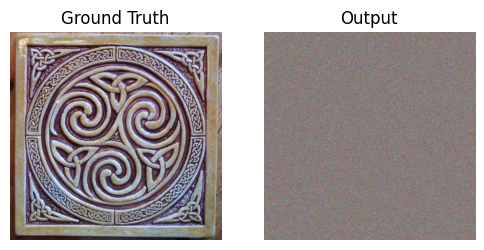

KeyboardInterrupt: 

In [23]:
for step in tqdm(range(args.niters)):

    loss_values = []
    # Process data points in batches
    for batch in train_dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        if args.inr_model == 'parac':
            inputs = inputs.unsqueeze(0)

        # Calculate model output
        if args.inr_model == 'incode':
            model_output, coef = model(inputs)
        else:
            model_output = model(inputs)

        # Calculate the output loss
        output_loss = ((model_output - targets)**2).mean()

        if args.inr_model == 'incode':
            # Calculate regularization loss for 'incode' model
            a_coef, b_coef, c_coef, d_coef = coef[0]
            reg_loss = args.a_coef * torch.relu(-a_coef) + \
                       args.b_coef * torch.relu(-b_coef) + \
                       args.c_coef * torch.relu(-c_coef) + \
                       args.d_coef * torch.relu(-d_coef)

            # Total loss for 'incode' model
            loss = output_loss + reg_loss
        else:
            # Total loss for other models
            loss = output_loss

        loss_values.append(loss.item())

        # Perform backpropagation and update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()


        break


    avg_loss = np.mean(loss_values)

    # Calculate PSNR
    with torch.no_grad():
        psnr = -10*torch.log10(((model_output - targets)**2).mean())
        psnr_train_values.append(psnr.item())

    # Adjust learning rate using a scheduler if applicable
    if args.using_schedular:
        scheduler.step()


    # Display intermediate results at specified intervals
    if step % args.steps_til_summary == 0:
        best_img = test(model)
        mse_loss_array = ((im - best_img)**2).mean().item()
        psnr_test = -10*np.log10(mse_loss_array)
        psnr_test_values.append(psnr_test.item())

        best_img = (best_img - best_img.min()) / (best_img.max() - best_img.min())

        print("Epoch: {} | Total Loss: {:.5f} | PSNR: {:.4f} | Test PSNR: {:.4f}".format(step,
                                                                                avg_loss,
                                                                                psnr.item(),
                                                                                psnr_test.item()))

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].set_title('Ground Truth')
        axes[0].imshow(im)
        axes[0].axis('off')
        axes[1].set_title('Output')
        axes[1].imshow(best_img)
        axes[1].axis('off')
        plt.show()


# Print maximum PSNR achieved during training
print('--------------------')
print('Train Max PSNR:', max(psnr_train_values))
print('Test Max PSNR:', max(psnr_test_values))
print('--------------------')

# Convergance Rate

In [ ]:
font = {'font': 'Times New Roman', 'size': 12}

plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(psnr_test_values[:-1])), psnr_test_values[:-1], label = f"{(args.inr_model).upper()}")
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('Image Inpainting', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()